In [1]:
import pandas as pd
import numpy as np
import pickle
# from numpy.random import RandomState
# from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import lightgbm as ltb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor

import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

## Read CSV
data_source = r"../data/vehicle_data/final_bat_auction_data.csv"
df = pd.read_csv(data_source)

print(f'Data ingested -- Found {len(df)} Rows')

/Users/andyczeropski/opt/miniconda3/envs/bat/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Data ingested -- Found 53343 Rows


In [2]:
df.head()
df.drop(["Mileage Notes", "Details"], inplace=True, axis=1)

In [4]:
# Check for nan values
# print('Before:\n', df.isna().sum())

# Drop any leftover nans
df = df.dropna()
print(df.Make.nunique())

print('STD DEV', df[df.Model== 'wrx sti']['Final Bid Price'].std(axis=0))
print(df[df.Model == 'wrx sti']["Final Bid Price"].mean())
print([price for price in df[df.Model == 'wrx sti']["Final Bid Price"]])

# Only keep certain models
makes = ["subaru", "volkswagen", "nissan", "honda", "ford", "mitsubishi", "mazda"]
df = df[df.Make.isin(makes)]
# df = df[df.Model.isin(["wrx sti"])]

# mod_lst = [model for model in df.Model.value_counts().loc[lambda x: x>4].index]
# df = df[df.Model.isin(mod_lst)]

# Get mean price per model
# means = df.groupby('Model')['Final Bid Price'].mean()
# model_means = [means[model] for model in df.Model]
# df['mean_model_price'] = model_means

# Check nan values again
print('\nAfter:\n', df.isna().sum())

target_feature = "Final Bid Price"

y = df[target_feature]
X = df.drop(target_feature, axis=1)
X.head()

7
STD DEV 32133.784396093906
34854.31623931624
[22250.0, 24000.0, 30249.0, 91500.0, 27500.0, 107000.0, 25500.0, 19000.0, 86500.0, 66000.0, 91000.0, 19750.0, 32250.0, 38000.0, 18250.0, 85000.0, 45000.0, 38000.0, 35500.0, 26000.0, 50000.0, 20000.0, 47000.0, 28700.0, 31000.0, 36000.0, 104000.0, 30000.0, 28000.0, 27500.0, 30500.0, 21000.0, 21000.0, 27000.0, 17305.0, 22250.0, 35000.0, 44700.0, 21050.0, 36000.0, 29555.0, 37000.0, 85600.0, 28000.0, 20250.0, 40500.0, 26687.0, 29555.0, 58500.0, 48000.0, 30250.0, 40000.0, 56000.0, 42250.0, 55500.0, 20500.0, 41000.0, 30000.0, 31000.0, 23000.0, 23000.0, 23000.0, 29252.0, 75209.0, 27555.0, 27851.0, 25500.0, 312555.0, 15000.0, 29500.0, 41900.0, 31000.0, 24750.0, 30000.0, 21250.0, 21000.0, 26750.0, 50500.0, 21250.0, 25000.0, 30000.0, 34250.0, 18400.0, 40750.0, 32500.0, 29500.0, 26250.0, 28000.0, 28750.0, 21500.0, 13250.0, 13750.0, 18350.0, 19750.0, 20150.0, 20500.0, 18500.0, 23500.0, 21250.0, 28000.0, 23500.0, 23000.0, 23750.0, 23750.0, 25000.0, 6455

,Make,Model,Year,Miles,color,auction_year,engine_size,cylinders
15973,ford,hot rod,1927,19.0,yellow,2022,3.883743,6.0
18356,ford,bronco 2nd generation 1978-1979,1978,59000.0,green,2022,5.751872,8.0
18357,ford,bronco 2nd generation 1978-1979,1979,92000.0,green,2022,5.751872,8.0
18358,ford,bronco 2nd generation 1978-1979,1979,75000.0,blue,2022,6.554840,8.0
18359,ford,bronco 2nd generation 1978-1979,1978,84000.0,black,2022,6.554840,8.0


In [36]:
print('STD DEV', df[df.Model== 'wrx sti']['Final Bid Price'].std(axis=0))
std = df[df.Model== 'wrx sti'][df['Final Bid Price'] > 0]['Final Bid Price'].std(axis=0)
std / df[df.Model== 'wrx sti'][df['Final Bid Price'] > 0]['Final Bid Price'].mean()

STD DEV 32133.784396093906


/var/folders/zc/257ljhc92snb384hphnpxgqc0000gn/T/ipykernel_85347/1425732034.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std = df[df.Model== 'wrx sti'][df['Final Bid Price'] > 0]['Final Bid Price'].std(axis=0)
/var/folders/zc/257ljhc92snb384hphnpxgqc0000gn/T/ipykernel_85347/1425732034.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std / df[df.Model== 'wrx sti'][df['Final Bid Price'] > 0]['Final Bid Price'].mean()


0.9219456257714925

In [282]:
# print(df.Model.unique())

df.shape

(9615, 9)

<AxesSubplot:>

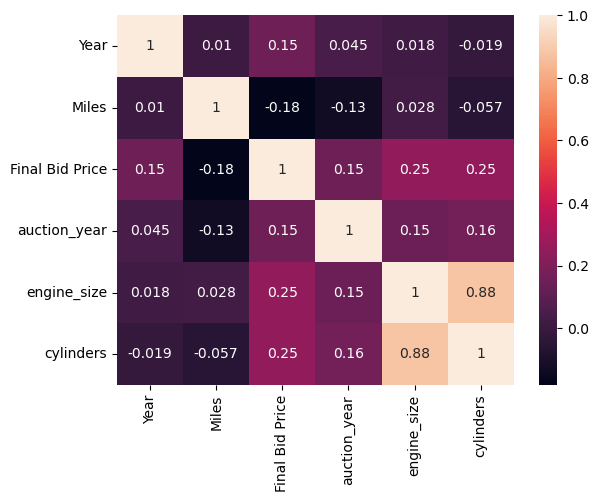

In [283]:
# sns.set(rc={"figure.figsize":(9, 9)})
sns.heatmap(df.corr(), annot = True)

In [284]:
## Find Numerical & Categorical Columns
# Get numerical and categorical feature columns
print('\nCalculating Numerical and Categorical Features...')
print(f'There are {len(X.columns)} total columns.')

numerical_features = X.select_dtypes(include='number').columns.tolist()
print(f'There are {len(numerical_features)} numerical features.')

categorical_features = X.select_dtypes(exclude='number').columns.tolist()
print(f'There are {len(categorical_features)} categorical features.', '\n')

print(X.columns)

## Pre-Process Data

print('Fetching Preprocessing Pipeline...\n')

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean', missing_values=np.nan)),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)


# Try this
# X_train_num = pd.DataFrame(numeric_pipeline.fit_transform(X_train[numerical_features]))
# X_train_num.columns = numeric_pipeline.get_feature_names_out()
# X_train_cat = pd.DataFrame(categorical_pipeline.fit_transform(X_train[categorical_features]))
# X_train_cat.columns = categorical_pipeline.get_feature_names_out()
# # X_train_merged = pd.concat([X_train_num, X_train_cat], ignore_index=True)
# X_train_merged = pd.concat([X_train_num, X_train_cat], axis=1)

# print(X_train_merged.head())

# print(X_train_num)


X_train_transformed = full_processor.fit_transform(X_train)
# X_valid_transformed = full_processor.transform(X_valid)

model = XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.1, verbosity=1)
# model = ltb.LGBMClassifier(random_state=42, n_estimators=100, max_depth=3, learning_rate=0.1, verbosity=1,
#                             early_stopping_rounds=10, eval_set=[(X_valid_transformed, y_valid)])


model_pipeline = Pipeline(steps=[
        ('preprocessor', full_processor),
        ('model', model)
    ])

# fit_params = {"model__eval_set": [(X_valid_transformed, y_valid)], 
#               "model__early_stopping_rounds": 5,
#               "model__verbosity": 0}

# model.set_params(**fit_params)


Calculating Numerical and Categorical Features...
There are 8 total columns.
There are 5 numerical features.
There are 3 categorical features. 

Index(['Make', 'Model', 'Year', 'Miles', 'color', 'auction_year',
       'engine_size', 'cylinders'],
      dtype='object')
Fetching Preprocessing Pipeline...



In [285]:
print(len(X_train), len(y_train))

7692 7692


In [286]:
# print(len(X_train), len(y_train))
# Preprocessing of training data, fit model 
# model_pipeline.fit(X_train, y_train, **fit_params)
hist = model_pipeline.fit(X_train, y_train)#, model__eval_metric=['mse'], model__eval_set=[(X_train, y_train), (X_valid_transformed, y_valid)], 
            #model__early_stopping_rounds=20)

In [287]:
# Preprocessing of validation data, get predictions
preds = model_pipeline.predict(X_valid)

# Evaluate the model
print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 9489.955366066206


In [251]:
# hist.get_booster().get_score(importance_type='gain')
# hist.named_steps['model'].get_booster().get_score(importance_type='weight')

## Testing Predictions

In [252]:
# X_valid[X_valid["Make"] == "Subaru"]
# X_valid.loc[[63667]]
# # X_valid.loc[[63607]]
# # y_valid.loc[[63667]]

In [254]:
tst_data = ["subaru", "wrx sti", 2004, 55000, "blue", 2022, 2.5, 4]
columns = ['Make', 'Model', "Year", 'Miles', 'color', 'auction_year', 'engine_size', 'cylinders']
tst = pd.DataFrame()
for idx, col in enumerate(columns):
    tst[col] = pd.Series(tst_data[idx])
preds = model_pipeline.predict(tst)
preds

array([24516.062], dtype=float32)

In [1]:
# X_processed = full_processor.fit_transform(X)
# print(X_processed)

## Train/Test Split

# X_train, X_valid, y_train, y_valid = train_test_split(X_processed, y, test_size=0.30, random_state=42)

## LightGBM Model Pipeline

# print('Creating LightGBM Model...\n')

# # Run model without params to perform grid search
# if do_grid_search:
#     model = ltb.LGBMClassifier(seed=42, verbose=1)

# # Run model with specified params
# else: 
#     # model = ltb.LGBMClassifier(seed=42, verbose=1, n_estimators = n_estimators, learning_rate = lr, max_depth = max_depth)
#     model = ltb.LGBMClassifier(random_state=42, n_estimators=n_estimators, num_leaves=64, max_depth=5, learning_rate=lr, n_jobs=-1)

# # Create model pipeline including preprocessor
# ltb_pipeline = Pipeline(steps=[
#     # ('preprocess', preprocessor),
#     ('model', model)
# ])

# print('Fitting XGBoost Model...\n')
# return ltb_pipeline

## Grid Search

# model = ltb.LGBMClassifier(seed=42, verbosity=2)

# param_dict = {
#     'model__learning_rate': [0.01, 1, 0.1],
#     'model__max_depth': range (1, 5, 1),
#     'model__n_estimators': range(60, 200, 40),
#     'model__early_stopping_rounds' : [30]
# }

# print('Starting Grid Search...\n')
# search = GridSearchCV(model, param_dict, 
#                   cv=3, 
#                   scoring='neg_mean_absolute_error',
#                   verbose=3)

# search.fit(X_train, y_train)

# print('Best score:', abs(search.best_score_))

# print('Best params:', search.best_params_)

# print('Best estimator:', search.best_estimator_)

# return search.best_params_.values()

## Training

# # Create and fit model
# lgb_model = ltb.LGBMClassifier(random_state=42, n_estimators=100, num_leaves=64, max_depth=5, learning_rate=0.1, n_jobs=-1, verbosity=3)
# improved_model = lgb_model.fit(X_train, y_train) 

# # Get predictions and output results
# preds = improved_model.predict(X_valid)
# MAE = mean_absolute_error(y_valid, preds)
# r2 = improved_model.score(X_valid, y_valid)
# print('MAE:', MAE)
# print('R2:', r2)

# # Create and fit model
# xgbr = XGBRegressor(seed=42, max_depth=3, learning_rate=0.1, verbosity=3)
# improved_model = xgbr.fit(X_train, y_train) 

# # Get predictions and output results
# preds = improved_model.predict(X_valid)
# MAE = mean_absolute_error(y_valid, preds)
# r2 = improved_model.score(X_valid, y_valid)
# print('MAE:', MAE)
# print('R2:', r2)

KeyboardInterrupt: 